### Data Load


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# seaborn setting
sns.set()

### 효율적 경계선 구현을 위한 최적화 알고리즘

In [3]:
# ETF Universe Ticker 설정
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

etf = yf.Tickers(tickers)

data = etf.history(start='2011-01-01', actions=False)
data.drop(['Open','High','Low','Volume'], inplace=True, axis=1) # 종가만 가져오기
data = data.droplevel(0, axis=1)

[*********************100%%**********************]  9 of 9 completed


In [4]:
data

Ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2011-01-03,29.541880,44.141167,10.376837,27.269773,21.118063,20.719322,20.057365,25.510992,32.104477
2011-01-04,29.343517,43.762417,10.364100,27.230951,21.200970,20.662846,20.152901,25.591240,31.926353
2011-01-05,29.412178,43.935741,10.485058,27.370710,21.325338,20.669912,20.025507,25.647417,32.189297
2011-01-06,29.259584,43.518475,10.415032,27.324127,21.449715,20.599325,20.044626,25.751743,31.994215
2011-01-07,29.229061,43.833031,10.325906,27.378477,21.350216,20.493431,20.114689,25.735691,31.977249
...,...,...,...,...,...,...,...,...,...
2024-02-22,86.320000,86.529999,40.099998,119.589996,205.770004,74.550003,61.520000,147.160004,182.110001
2024-02-23,86.830002,85.959999,40.299999,120.220001,205.289993,74.779999,61.959999,147.860001,181.289993
2024-02-26,86.309998,86.260002,40.099998,120.040001,205.490005,74.480003,60.740002,147.100006,181.850006


In [5]:
# 수익률 데이터
rets = data.pct_change().fillna(0)

# 기대 수익률 데이터
expected_return = rets.mean()*252

# 공분산행렬
cov = rets.cov()*252

In [6]:
expected_return

Ticker
XLB    0.104121
XLE    0.090635
XLF    0.128285
XLI    0.132390
XLK    0.195891
XLP    0.107389
XLU    0.102090
XLV    0.146395
XLY    0.152866
dtype: float64

### 포트폴리오 시뮬레이션

In [7]:
# 포트폴리오 수익률/변동성을 위한 빈 리스트 생성
p_returns    = [] # 수익률
p_volatility = [] # 변동성

In [8]:
# 자산의 개수
noa = len(tickers)

# 시뮬레이션 횟수
n_ports = 10000

In [9]:
# 시뮬레이션 실행
for n_port in range(n_ports):
    # 난수 기반 임의 투자 가중치 생성
    weights = np.random.random(noa)
    weights /= np.sum(weights)

    # 포트폴리오 수익률과 변동성 계산
    ret = np.dot(weights, expected_return)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    # 1회 시뮬레이션을 통해 얻어낸 포트폴리오 수익률과 변동성 데이터를 리스트에 저장
    p_returns.append(ret)
    p_volatility.append(vol)


In [10]:
# 포트폴리오 수익률/변동성을 배열로 변환
prets = np.array(p_returns)
pvols = np.array(p_volatility)

### 난수 생성을 통한 포트폴리오 시뮬레이션 시각화

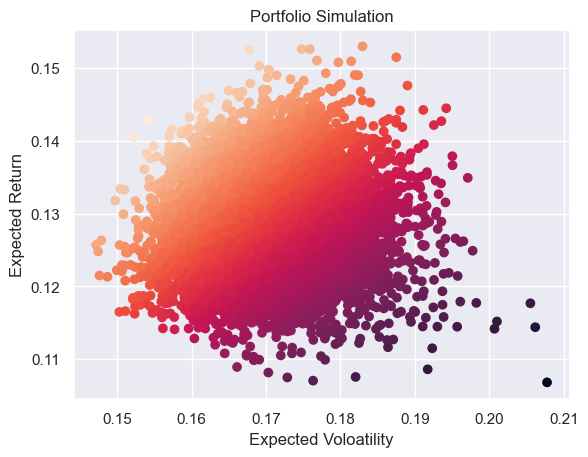

In [11]:
# 산포도를 이용한 시뮬레이션 결과 시각화
# x-axis : 포트폴리오 변동성
# y-axis : 포트폴리오 수익률
# 색깔 : 포트폴리오 샤프비율
plt.scatter(x=pvols, y=prets, c=prets/pvols, marker='o')

plt.xlabel("Expected Voloatility")
plt.ylabel("Expected Return")
plt.title("Portfolio Simulation")
plt.show()

### 최적화 모듈
```
scipy.optimize.minimize(
    fun         : 목적함수
    x0          : 초기값
    args        : 초기값 외에 목적함수에 전달한 인자
    method      : 최적화를 수행할 알고리즘의 종류
    bounds      : 상하한 경계값
    constraints : 제약조건
)
```

### 효율적 경계선 구현

In [12]:
import scipy.optimize as sco

def statistics(weights, expected_return, cov):
    '''
    포트폴리오 통계치 계산 함수
    '''
    # 투자 가중치
    weights = np.array(weights)

    # 포트폴리오 수익률
    prets = np.sum(expected_return*weights)

    # 포트폴리오 변동성
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    # 포트폴리오 수익률과 변동성, 사프 비율을 반환
    return np.array([prets, pvol, prets/pvol])

In [13]:
# 난수 기반 가중치 데이터 생성
weights = np.random.random(noa)
weights /= np.sum(weights)

In [14]:
# 목적함수 정의 (포트폴리오 변동성)
def obj_function(weights, expected_return, cov):
    return statistics(weights, expected_return, cov)[1]

In [36]:
# 수익률 수준별 포트폴리오 최적화 수행
t_rets = np.linspace(0.09, 0.20, 50)
t_vols = []

# 각 목표 수익률에 맞는 포트폴리오 변동성 레벨 계산
for t_ret in t_rets:
    # 투자 가중치 초기값 = 동일 가중 
    # 초기에는 모든 포트폴리오에 대해 동일한 가중치를 부여함 (= 1 / 포트폴리오 수)
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 (포트폴리오 목표 수익률, 현금 보유 비중 0)
    constraints = ({'type' : 'eq', 'fun' : lambda x:statistics(x, expected_return, cov)[0] - t_ret},
                   {'type' : 'eq', 'fun' : lambda x:np.sum(x)-1})
    
    # 자산별 경계조건 (숏 포지션 불가능)
    bounds = tuple((0.0, 1.0) for x in weights)
    
    # 최적화 알고리즘 수행
    results = sco.minimize(obj_function,
                            init_guess,
                            args = (expected_return, cov),
                            method = 'SLSQP',
                            bounds = bounds,
                            constraints = constraints)

    # 최적화 알고리즘을 통해 찾아낸 최적 포트폴리오의 변동성 값을 리스트에 저장
    t_vols.append(results['fun'])

t_vols = np.array(t_vols)


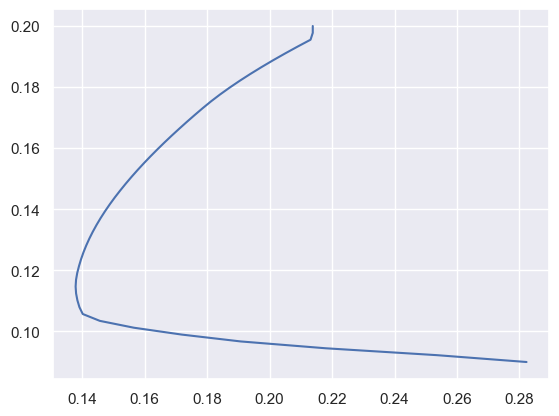

In [37]:
plt.plot(t_vols, t_rets)

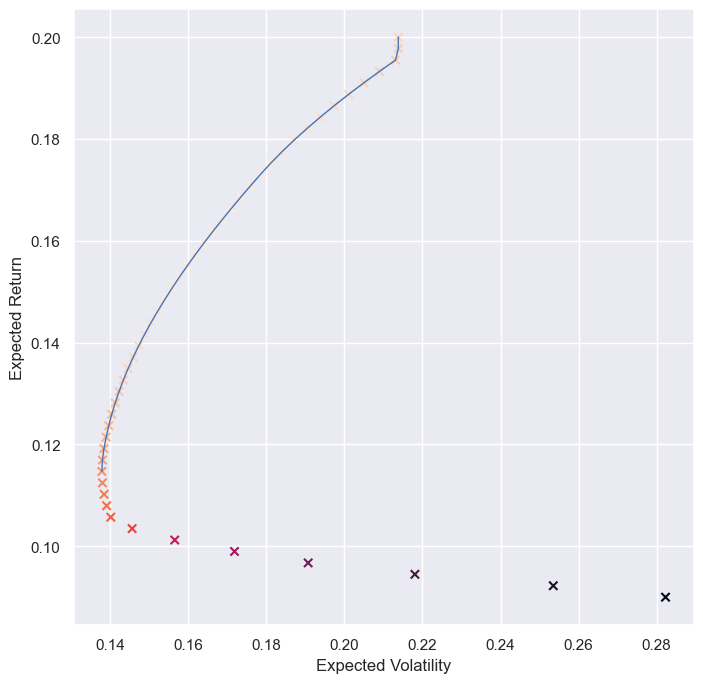

In [38]:
# 좌측 경계선 데이터 수집
ind = np.argmin(t_vols)
e_vols = t_vols[ind:]
e_returns = t_rets[ind:]

# 효율적 경계선 시각화
plt.figure(figsize=(8, 8))
plt.scatter(t_vols, t_rets, c=t_rets/t_vols, marker='x')
plt.plot(e_vols, e_returns, lw=1.0)
plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.show()